In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Getting Data

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [5]:
train = train_df.drop('ID',axis=1)
test = test_df.drop('ID',axis=1)

## Explore Data

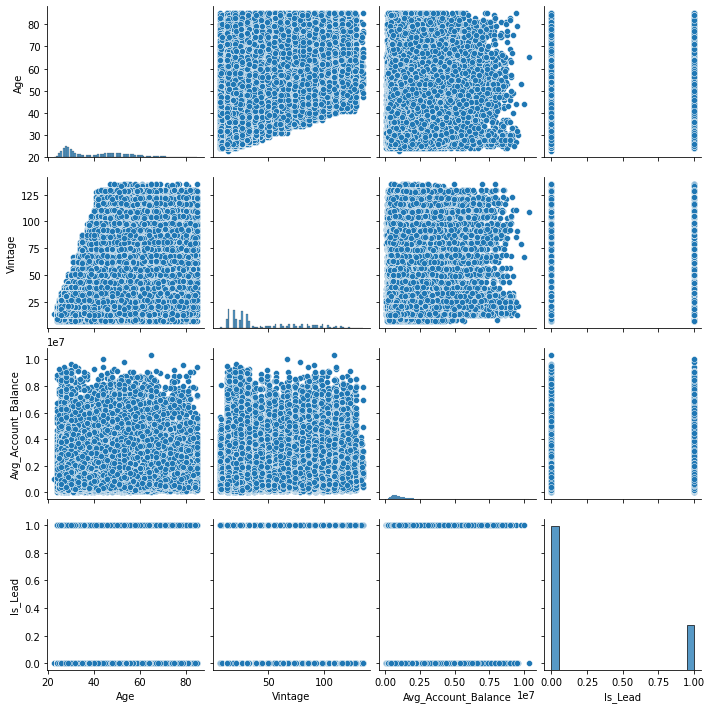

In [6]:
sns.pairplot(train)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


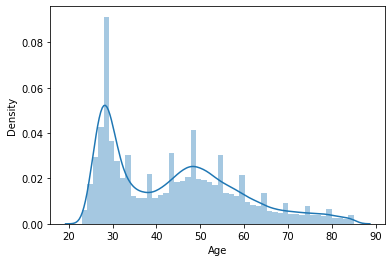

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


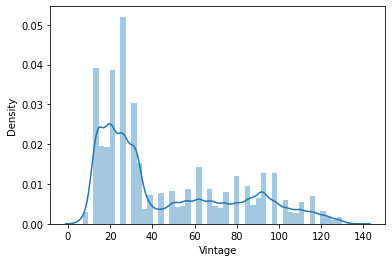

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


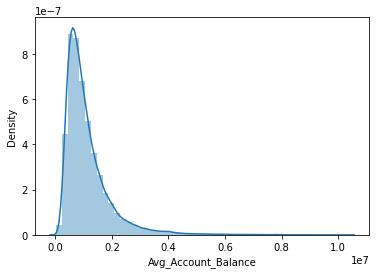

In [7]:
df = train
num_cols = df.dtypes[df.dtypes != np.object].index.values.tolist()
for c in num_cols:
  if c != 'Is_Lead':
    sns.distplot(df[c])
    plt.show()


## Normalize data

In [8]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=10, random_state=0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


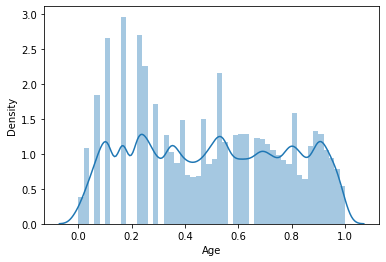

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


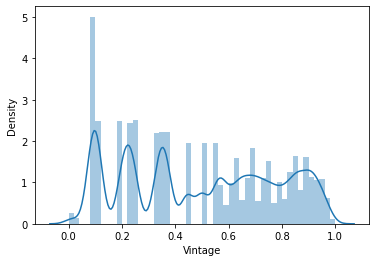

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


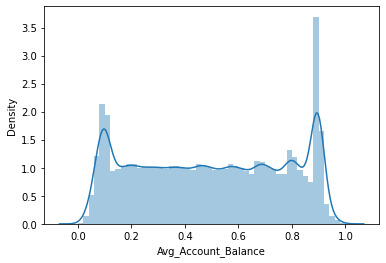

In [9]:
for c in num_cols:
  if c != 'Is_Lead':
    df[c] = qt.fit_transform(np.array(df[c]).reshape(-1, 1))
    test[c] = qt.transform(np.array(test[c]).reshape(-1, 1))
    sns.distplot(df[c])
    plt.show()

## Handle Outliers

In [10]:
from scipy import stats
z = np.abs(stats.zscore(df.Avg_Account_Balance))
df.Avg_Account_Balance = np.where(z < 3,df.Avg_Account_Balance,df.Avg_Account_Balance.median())


## Handle Missing

In [11]:

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [13]:

train_objs_num = len(df)
# data = pd.concat(objs=[df, test], axis=0,ignore_index=True)

In [ ]:

dataset = pd.concat(objs=[df, test], axis=0)
dfx = dataset.drop('Is_Lead',axis=1)

df1 = imputation(dfx,['Credit_Product','Gender','Region_Code','Occupation','Channel_Code','Is_Active'])
df1['Is_Lead'] = dataset['Is_Lead']
train_new = df1[:train_objs_num]
test_new = df1[train_objs_num:]


In [16]:
df1.isnull().sum()

Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product              0
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
dtype: int64

In [17]:
test_new = test_new.assign(ID = test_df.ID.tolist())
train_new = train_new.assign(ID = train_df.ID.tolist())

In [18]:
train_new.to_csv('trainnew.csv',index=False)
test_new.to_csv('testnew.csv',index=False)

## Encoding

In [ ]:
train_new = pd.read_csv('/content/drive/MyDrive/trainnew.csv')
test_new = pd.read_csv('/content/drive/MyDrive/testnew.csv')

In [20]:
train_new1 = train_new.drop('ID',axis=1)
test_new1 = test_new.drop('ID',axis=1)
train_objs_num = len(train_new1)
data = pd.concat(objs=[train_new1, test_new1], axis=0,ignore_index=True)
dataset_preprocessed = pd.get_dummies(data,drop_first=True)
train_preprocessed = dataset_preprocessed[:train_objs_num]
test_preprocessed = dataset_preprocessed[train_objs_num:]
X = train_preprocessed.drop('Is_Lead',axis=1)
Xtest = test_preprocessed.drop('Is_Lead',axis=1)
y = train_preprocessed['Is_Lead']

## Balancing

In [21]:
# import library
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

X = pd.DataFrame(x_smote, columns=X.columns)
y = pd.DataFrame(y_smote, columns=['Is_Lead'])


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0.0: 187437, 1.0: 58288})
Resample dataset shape Counter({0.0: 187437, 1.0: 187437})


## Modelling

In [22]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

In [23]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from xgboost.sklearn import XGBClassifier

In [ ]:
# XGBClassifier()

# n_jobs=-1
# verbosity=2
# silent=0
# tree_method = 'gpu_hist'

In [24]:
space = {'booster': hp.choice('booster', ['gbtree', 'gblinear' , 'dart']),
         'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1),
         'colsample_bynode': hp.uniform('colsample_bynode', 0.7, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
         'gamma': hp.uniform('gamma', 0, 0.5),
         'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 100,5),
         'learning_rate' : hp.choice('learning_rate', [0.001,0.01,0.1,0.3]),
         'max_delta_step' : hp.choice('max_delta_step', [0,1,2]),
         'max_depth' : hp.choice('max_depth', [3,5,7,9]),
         'min_child_weight' : hp.choice('min_child_weight', [1,3,5]),
         'objective' : hp.choice('objective', ['binary:logistic', 'binary:logitraw' , 'binary:hinge']),
         'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10]),
         'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10]),
         'subsample' : hp.choice('subsample', [0.5,0.7,0.9,1]),
         'eval_metric': hp.choice('eval_metric', ['auc'])

    }

In [25]:
def objective(space):
    model = XGBClassifier(
                          booster = space['booster'],
                          colsample_bylevel = space['colsample_bylevel'],
                          colsample_bynode = space['colsample_bynode'],

                          colsample_bytree = space['colsample_bytree'],
                          gamma = space['gamma'],
                          scale_pos_weight = space['scale_pos_weight'],
                          learning_rate = space['learning_rate'], 
                          max_delta_step = space['max_delta_step'],

                          max_depth = space['max_depth'],
                          min_child_weight = space['min_child_weight'], 
                          objective = space['objective'],
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'], 

                          subsample = space['subsample'],
                          eval_metric = space['eval_metric'],
                          tree_method = 'gpu_hist',
                          n_jobs=-1,
                          verbosity=1
                          )
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, verbose=1, scoring='roc_auc', cv=cv,).mean()
    

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 30,
            trials= trials)
best

  0%|          | 0/30 [00:00<?, ?it/s, best loss: ?]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



  3%|▎         | 1/30 [00:27<13:19, 27.59s/it, best loss: -0.6870142878049229]

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  7%|▋         | 2/30 [05:01<47:21, 101.47s/it, best loss: -0.7299327212650373]

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.6min finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



 10%|█         | 3/30 [18:24<2:20:19, 311.85s/it, best loss: -0.7697709282193996]

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.4min finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



 13%|█▎        | 4/30 [19:44<1:45:04, 242.46s/it, best loss: -0.775632443310644] 

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



In [ ]:
# li = ['auc', 'error' , 'logloss']
# dic ={}
# for i,v in enumerate(li):
#   dic[i] = v
# dic

In [ ]:
booster = {0: 'gbtree', 1: 'gblinear', 2: 'dart'}
objective = {0: 'binary:logistic', 1: 'binary:logitraw', 2: 'binary:hinge'}
learning_rate = {0: 0.001, 1: 0.01, 2: 0.1, 3: 0.3}

max_delta_step = {0: 0, 1: 1, 2: 2}
max_depth = {0: 3, 1: 5, 2: 7, 3: 9}
min_child_weight = {0: 1, 1: 3, 2: 5}

reg_alpha = {0: 1e-05, 1: 0.01, 2: 0.1, 3: 1, 4: 10}
reg_lambda = {0: 1e-05, 1: 0.01, 2: 0.1, 3: 1, 4: 10}
subsample = {0: 0.5, 1: 0.7, 2: 0.9, 3: 1}

eval_metric = {0: 'auc', 1: 'error', 2: 'logloss'}


In [ ]:
print(booster[best['booster']])
print(learning_rate[best['learning_rate']])
print(objective[best['objective']])

print(max_delta_step[best['max_delta_step']])
print(max_depth[best['max_depth']])
print(min_child_weight[best['min_child_weight']])

print(reg_alpha[best['reg_alpha']])
print(reg_lambda[best['reg_lambda']])
print(subsample[best['subsample']])

print(eval_metric[best['eval_metric']])

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score

In [ ]:
trainedforest = XGBClassifier(
                          booster = booster[best['booster']],
                          colsample_bylevel = best['colsample_bylevel'],
                          colsample_bynode = best['colsample_bynode'],

                          colsample_bytree = best['colsample_bytree'],
                          gamma = best['gamma'],
                          scale_pos_weight = best['scale_pos_weight'],
                          learning_rate = learning_rate[best['learning_rate']], 
                          max_delta_step = max_delta_step[best['max_delta_step']],

                          max_depth = max_depth[best['max_depth']],
                          min_child_weight = min_child_weight[best['min_child_weight']], 
                          objective = objective[best['objective']],
                          reg_alpha = reg_alpha[best['reg_alpha']],
                          reg_lambda = reg_lambda[best['reg_lambda']], 

                          subsample = subsample[best['subsample']],
                          eval_metric = eval_metric[best['eval_metric']],
                          tree_method = 'gpu_hist',
                          n_jobs=-1,
                          verbosity=2,
                          silent=0
                          ).fit(X,y)
predictionforest = trainedforest.predict(X_test)
print(accuracy_score(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
print(roc_auc_score(y_test,predictionforest))

In [ ]:
pred = trainedforest.predict_proba(Xtest)
sns.distplot(pred)

## Result

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/testnew.csv')
result = pd.DataFrame(test_df.ID,columns=['ID'])

li = []
for i in pred:
  li.append(i[1])

result['Is_Lead'] = li
result.to_csv('result8.csv',index=False)